In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys

from numba import jit, vectorize, float64, prange
from os.path import exists
from scipy.stats import qmc
from timeit import default_timer as timer

mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [3]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.zeros(len(samples), dtype = np.int32)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

def create_batch_uniform(N, re_low, re_high, im_low, im_high):
    samples_re = np.random.uniform(low = re_low, high = re_high, size = N)
    samples_im = np.random.uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

def create_batch_lhc(n, lhc_sampler, re_low, re_high, im_low, im_high):
    sample = lhc_sampler.random(n)
    l_bounds = [re_low, im_low]
    u_bounds = [re_high, im_high]
    return qmc.scale(sample, l_bounds, u_bounds)

In [4]:
@jit(nopython = True)
def set_count_from_iter_counts(max_iter, iter_counts):
    set_count = 0
    for count in iter_counts:
        if count == max_iter - 1:
            set_count += 1
    return set_count

@jit(nopython = True)
def area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, max_iter):
    n = len(iter_counts)
    set_count = set_count_from_iter_counts(max_iter, iter_counts)
    domain_area = (re_high - re_low) * (im_high - im_low)
    return domain_area * set_count / n

In [5]:
@jit(nopython = True, parallel = True, nogil = True)
def mandelbrot_mc(max_iter, samples):
    """
    Counts the number of complex numbers in `samples` that do
    not meet the escape condition in `max_iter` recursions of
    the Mandelbrot polynomial, z(n+1) = z(n)^2 + c
    
    The escape condition used is |z(n)| >= 2
    
    Parameters
    ----------
    max_iter: positive integer
        Value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        values of z(0)
        
    Returns
    -------
    set_count: positive integer
        Number of complex numbers in `samples` that remain
        that do not satisfy the escape condition
    """
    set_count = 0
    for i in prange(len(samples)):
        c = samples[i]
        zn = c
        for j in range(1, max_iter):
            zn = zn*zn + c
            if (np.abs(zn) > 2):
                # numba should recognize this as a critical section
                break
            elif j == max_iter - 1:
                set_count += 1
    return set_count

@jit(nopython = True, nogil = True, parallel = True)
def mandelbrot_mc_area(re_low, re_high, im_low, im_high, max_iter, samples):
    """
    Calculates estimator of the area of the Mandelbrot set
    
    Parameters
    ----------
    re_low, re_high, im_low, im_high: float or float-like
        corners of bounding rectangle in the complex plane
    
    max_iter: positive integer
        value of n up to which z(n) is evaluated
    
    samples: array of complex numbers
        list of c values, assumed to be drawn from a uniform distribution
        in the bounding region
        
    Returns
    -------
    area: default numpy float (float32 or float64)
        estimate of the area of the mandelbrot set
    """
    count = mandelbrot_mc(max_iter, samples)
    return mandelbrot_area(count, len(samples), re_low, re_high, im_low, im_high)

@jit(nopython = True)
def mandelbrot_area(count, N, re_low, re_high, im_low, im_high):
    """
    TODO: Add docstring
    """
    rect_area = (re_high - re_low) * (im_high - im_low)
    return rect_area * count / N

@jit(nopython = True)
def mandelbrot_mc_runs(max_iter, samples, runs_count):
    counts = np.zeros(runs_count)
    for _ in range(runs_count):
        counts[i] = mandelbrot_mc(max_iter, samples)
    return counts

@jit(nopython = True)
def sample_mean_variance(counts):
    """Returns sample mean and sample variance of input array
    Parameters
    ----------
    counts: array of numbers
    
    Returns: 2-tuple (sample mean, sample variance)
    """
    n = len(counts)
    assert n > 1
    sample_mean = np.mean(counts)
    sample_variance = np.sum(np.power(counts - sample_mean, 2))/(n - 1)
    return (sample_mean, sample_variance)

In [6]:
N = 10**6
i = 1000
re_low, re_high = -2., 1.
im_low, im_high = -1.5, 1.5
area = (re_high - re_low) * (im_high - im_low)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [7]:
start_time = timer()
count = mandelbrot_mc_default(i, samples)
end_time = timer()
print(f"Execution time: {np.round(end_time - start_time, 2)} seconds")

Execution time: 1.25 seconds


In [8]:
# [WARN]: On Linux Mint 20, 16GB RAM, 2GB swap space, the kernel crashes as it runs out of memory for N = 1.0e9
N = 10**8
# TODO: save large random arrays
np.random.seed(10010)
samples = create_batch_uniform(N, re_low, re_high, im_low, im_high)

In [9]:
start_time = timer()
count = mandelbrot_mc_default(i,samples)
end_time = timer()
print(end_time - start_time)

12.4159062860017


For a fixed $i$, $\lim_{s\to\infty}A_{i,s} = A_i > A_\text{M}$, i.e. we are essentially calculating the area of a superset of the Mandelbrot set, one that includes points that would have met the escape condition after $i$ iterations.

Given a strictly increasing sequence of $i$-values $\{i_1, i_2, \ldots i_n\}$, we would like to pick $i = i_k$ for the smallest $k$ such that $|A_{k+1} - A_{k}|$ is less than some threshold value.

Henceforth, we simulate only the top half of the mandelbrot set.

In [10]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)
if not exists("monte_carlo_random_sampling.npz"):
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
                samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez("monte_carlo_random_sampling.npz", mean_areas, sample_variances)
else:
    save_data = np.load("monte_carlo_random_sampling.npz")
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [12]:
print(mean_areas*2)

[[1.591074   1.5889284  1.58844132 1.58851555 1.58872452]
 [1.549566   1.5464808  1.54715598 1.54671338 1.54648228]
 [1.528254   1.5274458  1.52588844 1.52616575 1.52616466]
 [1.51677    1.5145002  1.5137145  1.5141101  1.51428353]
 [1.51857    1.5100632  1.5106176  1.51045636 1.51032711]
 [1.516644   1.5078762  1.5076512  1.50836897 1.50850734]]


In [14]:
sample_variances

array([[3.35670695e-04, 2.75704626e-05, 2.39906564e-06, 3.73360177e-07,
        3.38882823e-08],
       [3.49306797e-04, 2.86546294e-05, 2.68041174e-06, 3.52640072e-07,
        3.49699459e-08],
       [2.97951144e-04, 2.57127797e-05, 3.24708862e-06, 2.92211211e-07,
        3.28233659e-08],
       [2.55705842e-04, 3.05981872e-05, 1.97818551e-06, 3.15487240e-07,
        3.14728060e-08],
       [2.77650230e-04, 2.78067413e-05, 2.89970495e-06, 2.57539900e-07,
        1.92595045e-08],
       [2.96124098e-04, 2.07872193e-05, 2.50242144e-06, 3.44111657e-07,
        1.96970277e-08]])

In [15]:
print((end_time - start_time)/60)

70.64204660185


In [ ]:
i_values = np.array([50, 100, 200, 500, 1000, 2000], dtype = np.int64) #TODO: tweak values
s_values = np.array([10**i for i in range(4,9)], dtype = np.int64)

npz_filename = "monte_carlo_lhc_sampling.npz"
if not exists(npz_file):
    # arrays have not been saved in the filesystem
    # perform the simulation from scratch
    re_low, re_high = -2., 1.
    im_low, im_high = 0, 1.5

    number_of_batches = 50
    mean_areas = np.zeros((len(i_values), len(s_values)))
    sample_variances = np.zeros((len(i_values), len(s_values)))

    start_time = timer()
    for k,i in enumerate(i_values):
        # repeat `number_of_batches` times for each s-value
        lhc_sampler = qmc.LatinHypercube(d = 2, seed = np.random.randint(100101))
        for l,s in enumerate(s_values):
            areas_batch = np.zeros(number_of_batches)
            for j in range(number_of_batches):
#                 samples = create_batch_uniform(s, re_low, re_high, im_low, im_high)
                samples = create_batch_lhc(s, lhc_sampler, re_low, re_high, im_low, im_high)
                iter_counts = mandelbrot_mc_default(i, samples)
                est_area = area_from_iter_counts(re_low, re_high, im_low, im_high, iter_counts, i)
                areas_batch[j] = est_area
            μ, svar = sample_mean_variance(areas_batch)
            mean_areas[k][l] = μ
            sample_variances[k][l] = svar
    end_time = timer()
    np.savez(npz_filename, mean_areas, sample_variances)
else:
    # loading results of previous simulation from file
    save_data = np.load(npz_filename)
    mean_areas = save_data['arr_0']
    sample_variances = save_data['arr_1']

In [9]:
# orthogonal sampling
nx = ny = n = 3
nsq = n*n
xlist = np.arange(nsq).reshape((n,n))
ylist = np.arange(nsq).reshape((n,n))
x_scale = 3.0/nsq
y_scale = 2.0/nsq
x_randos = []
y_randos = []
for i in range(n):
    xlist[i] = np.random.permutation(xlist[i])
    ylist[i] = np.random.permutation(ylist[i])
for i in range(n):
    for j in range(n):
        x = -2.0 * x_scale + xlist[i][j] + np.int32(np.random.uniform())
        y = -1.0 * y_scale + ylist[j][i] + np.int32(np.random.uniform())
        x_randos.append(x)
        y_randos.append(y)
            

In [10]:
len(x_randos)

9

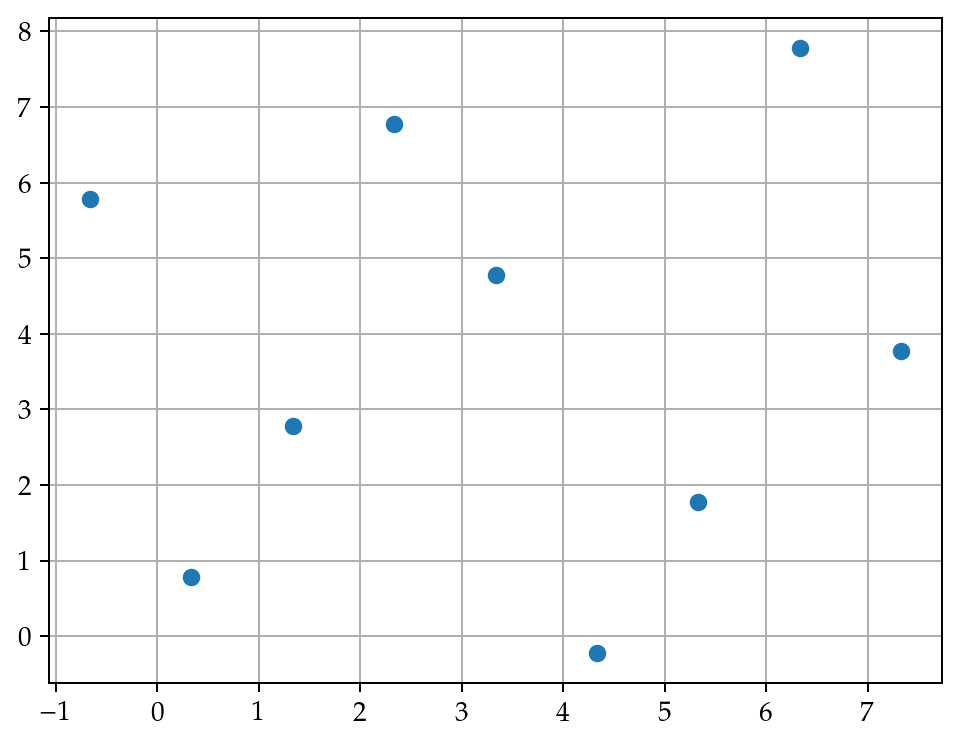

In [12]:
plt.scatter(x_randos, y_randos)
plt.grid(b = True)
plt.show()